# Calculating the $S_3$ for the simulations 
Calculate $S_3(r)$ so that we can estimate the energy injection rates

The definition is simple, we do:
$$
\langle \left[\left(\vec v\left(\vec r+\vec\ell\right)-\vec v\left(\vec r\right)\right)\cdot\frac{\vec \ell}{\ell}\right]^3\rangle
$$

In [1]:
import numpy as np
from scipy import stats

""" Calculate the energy spectrum as a function of radius

Parameters
----------
data : dict
       Athena dictionary of primitive values
dust : bool, optional
       If the energy spectrum of the dust (True) or gas (False) component should be calculated. Default: False.
       
Returns
-------
bins  : ndarray
        1D array of frequency bins for which the spectrum was calculated
datab : ndarray
        1D array containing the energy spectrum
"""

def energySpectrum(data,dust=False):

    n1,n2,n3 =data['RootGridSize']
    x3 = data['x3v']
    d3 = data['x3f'][1]-data['x3f'][0]
    f3 = 1./d3
    
    if(dust):
        v1 = data['vp1']
        v2 = data['vp2']
        v3 = data['vp3']
        rho= data['rhop']
    else:
        v1 = data['vel1']
        v2 = data['vel2']
        v3 = data['vel3']
        rho= data['rho']

    fftv1 =np.fft.fftn(v1)/(n1*n2*n3)
    fftv2 =np.fft.fftn(v2)/(n1*n2*n3)
    fftv3 =np.fft.fftn(v3)/(n1*n2*n3)

    k3 = np.fft.fftfreq(n3, d3)
    #k3 = k3[:k3.size//2]
    k = np.sqrt(k3[:,None,None]*k3[:,None,None]+k3[None,:,None]*k3[None,:,None]+k3[None,None,:]*k3[None,None,:])
    #k.shape
    Ek = np.real(fftv1*fftv1.conjugate()+fftv2*fftv2.conjugate()+fftv3*fftv3.conjugate())
    
    kmax=np.ceil(np.amax(k))
    bins_edge = np.arange(1.0,kmax,1)-0.5
    bins = np.arange(1.0,kmax-1,1)

    espec = np.stack((k.flatten(),Ek.flatten()),axis=-1)
    #print data.shape
    datab,__,__ = stats.binned_statistic(espec[:,0],espec[:,1],bins=bins_edge,statistic='sum')
    
    return bins,datab/2.0
    
"""Calculates the vorticity

Calculates the components of the 3 dim. vorticity vector assuming periodic boundaries in all dimensions

Parameters
----------
data : dict
       Athena dictionary of primitive values

Returns
-------
vox, voy, voz : ndarray
                3 dim. arrays containing the x, y ,z component of vorticity, respecitively

"""    
    
def vorticity(data):
    
    #get box size
    L1 = data['RootGridX1'][2]
    L2 = data['RootGridX2'][2]
    L3 = data['RootGridX3'][2]
    
    #get cell center positions and add periodic boundary values
    x = np.append(np.insert(data['x1v'],0,data['x1v'][-1]-L1),data['x1v'][0]+L1)
    y = np.append(np.insert(data['x2v'],0,data['x2v'][-1]-L2),data['x2v'][0]+L2)
    z = np.append(np.insert(data['x3v'],0,data['x3v'][-1]-L3),data['x3v'][0]+L3)
    
    
    #get velocities and assign boundary values (periodic for now)
    n3,n2,n1=data["RootGridSize"]
    
    vx =np.empty((n1+2,n2+2,n3+2))
    vy =np.empty((n1+2,n2+2,n3+2))
    vz =np.empty((n1+2,n2+2,n3+2))
    
    vx[1:-1,1:-1,1:-1] = np.swapaxes(data['vel1'],0,2)
    vy[1:-1,1:-1,1:-1] = np.swapaxes(data['vel2'],0,2)
    vz[1:-1,1:-1,1:-1] = np.swapaxes(data['vel3'],0,2)
    
    vx[0,:,:]  = vx[-2,:,:]
    vx[-1,:,:] = vx[1,:,:]
    vy[:,0,:]  = vy[:,-2,:]
    vy[:,-1,:] = vy[:,1,:]
    vz[:,:,0]  = vz[:,:,-2]
    vz[:,:,-1] = vz[:,:,1]
    
    #initialize vorticity arrays
    
    vox = np.zeros(tuple(data["RootGridSize"]))
    voy = np.zeros(tuple(data["RootGridSize"]))
    voz = np.zeros(tuple(data["RootGridSize"]))
    
    #calculate vorticity using second order central derivatives inside domain
    vox = (vz[1:-1,2:,1:-1]-vz[1:-1,:-2,1:-1])/((y[2:]-y[:-2])[None,:,None]) \
        - (vy[1:-1,1:-1,2:]-vy[1:-1,1:-1,:-2])/((z[2:]-z[:-2])[None,None,:]) #dy vz -dz vy
    
    voy = (vx[1:-1,1:-1,2:]-vx[1:-1,1:-1,:-2])/((z[2:]-z[:-2])[None,None,:]) \
        - (vz[2:,1:-1,1:-1]-vz[:-2,1:-1,1:-1])/((x[2:]-x[:-2])[:,None,None]) #dz vx -dx vz
    
    voz = (vy[2:,1:-1,1:-1]-vy[:-2,1:-1,1:-1])/((x[2:]-x[:-2])[:,None,None]) \
        - (vx[1:-1,2:,1:-1]-vx[1:-1,:-2,1:-1])/((y[2:]-y[:-2])[None,:,None]) #dx vy -dy vx
    
    return vox,voy,voz
    
    
"""Calculate Kolmogorov time microscale
   
   Calculate time scale corresponding to the Kolmogorove microscale using the full Strain-Rate tensor.

Parameters
----------
data : dict
       Athena dictionary of primitive values

Returns
-------
tscale : float
         Time mircoscale


"""
def tMicroscale(data):
    
    #get box size
    L1 = data['RootGridX1'][2]
    L2 = data['RootGridX2'][2]
    L3 = data['RootGridX3'][2]
    
    #get cell center positions and add periodic boundary values
    x = np.append(np.insert(data['x1v'],0,data['x1v'][-1]-L1),data['x1v'][0]+L1)
    y = np.append(np.insert(data['x2v'],0,data['x2v'][-1]-L2),data['x2v'][0]+L2)
    z = np.append(np.insert(data['x3v'],0,data['x3v'][-1]-L3),data['x3v'][0]+L3)
    
    
    #get velocities and assign boundary values (periodic for now)
    n3,n2,n1=data["RootGridSize"]
    
    vx =np.empty((n1+2,n2+2,n3+2))
    vy =np.empty((n1+2,n2+2,n3+2))
    vz =np.empty((n1+2,n2+2,n3+2))
    
    vx[1:-1,1:-1,1:-1] = np.swapaxes(data['vel1'],0,2)
    vy[1:-1,1:-1,1:-1] = np.swapaxes(data['vel2'],0,2)
    vz[1:-1,1:-1,1:-1] = np.swapaxes(data['vel3'],0,2)
    
    vx[0,:,:]  = vx[-2,:,:]
    vx[-1,:,:] = vx[1,:,:]
    vy[:,0,:]  = vy[:,-2,:]
    vy[:,-1,:] = vy[:,1,:]
    vz[:,:,0]  = vz[:,:,-2]
    vz[:,:,-1] = vz[:,:,1]
    
    #initialize Strain rate tensor array (only 6 components as tensor is symmetric)
    
    E = np.zeros((6,n1,n2,n3))
    
    #calculate vorticity using second order central derivatives
    
    E[0,:,:,:] = (vx[2:,1:-1,1:-1]-vx[:-2,1:-1,1:-1])/((x[2:]-x[:-2])[None,None,:]) #E11 = dx vx
    
    E[1,:,:,:] = (vy[1:-1,2:,1:-1]-vy[1:-1,:-2,1:-1])/((y[2:]-y[:-2])[:,None,None]) #E22 = dy vy
    
    E[2,:,:,:] = (vz[1:-1,1:-1,2:]-vz[1:-1,1:-1,:-2])/((z[2:]-z[:-2])[None,:,None]) #E33 = dz vz
    
    E[3,:,:,:] = 0.5*((vy[2:,1:-1,1:-1]-vy[:-2,1:-1,1:-1])/((x[2:]-x[:-2])[:,None,None])
                          + (vx[1:-1,2:,1:-1]-vx[1:-1,:-2,1:-1])/((y[2:]-y[:-2])[None,:,None])) #E12=E21= dx vy +dy vx
    
    E[4,:,:,:] = 0.5*((vx[1:-1,1:-1,2:]-vx[1:-1,1:-1,:-2])/((z[2:]-z[:-2])[None,None,:])
                          + (vz[2:,1:-1,1:-1]-vz[:-2,1:-1,1:-1])/((x[2:]-x[:-2])[:,None,None])) #E13=E31= dz vx +dx vz
    
    E[5,:,:,:] = 0.5*((vz[1:-1,2:,1:-1]-vz[1:-1,:-2,1:-1])/((y[2:]-y[:-2])[None,:,None])
                          + (vy[1:-1,1:-1,2:]-vy[1:-1,1:-1,:-2])/((z[2:]-z[:-2])[None,None,:])) #E23=E32= dy vz +dz vy
    
    
    tinv = np.sqrt(2.0*np.mean(E[0]*E[0]+E[1]*E[1]+E[2]*E[2]+2*E[3]*E[3]+2*E[4]*E[4]+2*E[5]*E[5]))
    
    return 1.0/tinv
    
 
""" Periodic Euclidean distance metric

Calculates the euclidean distance between point x and point y assuming a periodic box with length boxl in all directions

Parameters
----------
x,y  : ndarray
       Points of which to calculate the mutual distance, trailing axes dimension has to match
boxl : float
       Length of the periodic box

Returns
-------
dist : float
       distance between points
 
"""
def distance(x,y,boxl):
    #calculate the distance form point x=(x1,x2,x3) to point y=(y1,y2,y3)
    #boxl = 1.0
    sep = np.abs(x - y)
    dist = np.sqrt(np.sum((np.where(sep>boxl/2.,np.abs(sep-boxl),sep))**2,axis=-1))
    return dist
    

 
"""Calculate the 3rd order longitudinal structure function for specific distance

Parameters
----------
data : dict
       Athena dictionary of primitive values

r    : float
       correlation distance 
       
Returns
-------
s3long : float

""" 
def S3longitudinal(data,r):
    z,y,x=np.meshgrid(data['x3v'],data['x2v'],data['x1v'],indexing='ij')
    pos3D=np.stack((x,y,z),axis=-1)
    dx=data['x3f'][1]-data['x3f'][0]
    
    #build initial distance mask
    xc = pos3D[0,0,0]
    dist = distance(pos3D,xc,1.0)
    cond = ((dist>r-dx*0.6) & (dist<r+dx*0.6))
    where = np.where(cond)
    
    s3sum = 0.0
    nitems = 0
    n3,n2,n1=data["RootGridSize"]
    for k in range(0,n3):
        for j in range(0,n2):
            for i in range(0,n1):
                #
                xc = pos3D[k,j,i]
                vc=np.array([data['vel1'][k,j,i],data['vel2'][k,j,i],data['vel3'][k,j,i]])
                
                #roll mask to new position
                mask = ((where[0]+k)%n3,(where[1]+j)%n2 ,(where[2]+i)%n1)
                
                vcond = np.stack((data['vel1'][mask],data['vel2'][mask],data['vel3'][mask]),axis=-1)
                poscond = pos3D[mask]

                
                rel = poscond - xc
                lens = np.sqrt(np.sum(rel**2,axis=-1))
                erel = rel/lens[:,None]

                s3sum += np.sum(np.power(np.sum((vcond-vc)*erel,axis=-1),3.0))
                nitems +=poscond.shape[0]
                #print(nitems,"\n")
    
    return s3sum/float(nitems)

In [1]:
import glob
import athena_read
import h5py
import matplotlib.pyplot as plt
def read_athdf(paths,sep=2):
    athdfs = []
    paths = [p for p in glob.glob(paths)]
    for i, path in enumerate(paths):
        athdfs.append(athena_read.athdf(path))
        if i % sep == 0:
            print(f'{i}:Loading {path}')
    print(f'Total of {len(athdfs)} files loaded')
    return athdfs

In [2]:
normal = read_athdf('../athenaMLdata/data/*103*')

0:Loading ../athenaMLdata/data/TurbPar.out2.00103.athdf
Total of 1 files loaded


In [3]:
def S3longitudinal_Sampling(data, r,samples=5000):
    z,y,x=np.meshgrid(data['x3v'],data['x2v'],data['x1v'],indexing='ij')
    pos3D=np.stack((x,y,z),axis=-1)
    dx=data['x3f'][1]-data['x3f'][0]
    
    #build initial distance mask
    xc = pos3D[0,0,0]
    dist = distance(pos3D,xc,1.0)
    cond = ((dist>r-dx*0.6) & (dist<r+dx*0.6))
    where = np.where(cond)
    
    #print(pos3D.shape)
    
    s3sum = 0.0
    nitems = 0
    n3,n2,n1=data["RootGridSize"]
    
    sample_coords = np.random.choice(n1*n2*n3,samples)
    
    for sample_coord in sample_coords:
        k,j,i = sample_coord % n3, (sample_coord//n3)%n2, ((sample_coord//n3)//n2)%n1
        
        xc = pos3D[k,j,i]
        vc=np.array([data['vel1'][k,j,i],data['vel2'][k,j,i],data['vel3'][k,j,i]])

        #roll mask to new position
        mask = ((where[0]+k)%n3,(where[1]+j)%n2 ,(where[2]+i)%n1)

        vcond = np.stack((data['vel1'][mask],data['vel2'][mask],data['vel3'][mask]),axis=-1)
        poscond = pos3D[mask]


        rel = poscond - xc
        lens = np.sqrt(np.sum(rel**2,axis=-1))
        erel = rel/lens[:,None]

        s3sum += np.sum(np.power(np.sum((vcond-vc)*erel,axis=-1),3.0))
        nitems +=poscond.shape[0]
        #print(nitems,"\n")
    
    return s3sum/float(nitems)

In [ ]:
s3_vals = []

In [37]:
for i in range(100):
    s3_vals.append(S3longitudinal_Sampling(normal[0],0.01,50000))
    if i % 100 == 0:
        print('Iteration: ', i+1)

Iteration:  1


Text(0.5, 1.0, 'Distribution of 200 for r = 0.01')

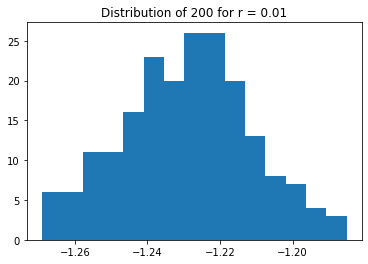

In [44]:
plt.hist(np.array(s3_vals)/1e-5,bins=15)
plt.title(f'Distribution of {len(s3_vals)} for r = {0.01}')

In [46]:
s3_val_2 = []
for i in range(1000):
    s3_val_2.append(S3longitudinal_Sampling(normal[0],0.06,1000))
    if i % 50 == 0:
        print('Iteration: ',i)

Iteration:  0
Iteration:  50
Iteration:  100
Iteration:  150
Iteration:  200
Iteration:  250
Iteration:  300
Iteration:  350
Iteration:  400
Iteration:  450
Iteration:  500
Iteration:  550
Iteration:  600
Iteration:  650
Iteration:  700
Iteration:  750
Iteration:  800
Iteration:  850
Iteration:  900
Iteration:  950


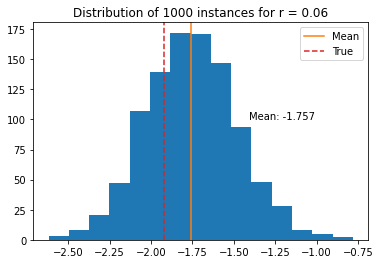

In [73]:
plt.hist(np.array(s3_val_2)/1e-4,bins=15)
plt.title(f'Distribution of {len(s3_val_2)} instances for r = {0.06}')
plt.axvline(np.mean(np.array(s3_val_2))/1e-4,color='tab:orange',label='Mean')
plt.text(0.8*np.mean(np.array(s3_val_2))/1e-4, 100,f'Mean: {np.mean(np.array(s3_val_2))/1e-4:.3f}')
plt.axvline(-0.00019207848434542844/1e-4,color='tab:red',ls='--',label='True')
plt.legend()

In [20]:
S3longitudinal(normal[0],0.01)

-1.2293694867510075e-05

In [113]:
rs = np.geomspace(1/128,1,50)
rs[5:9]

array([0.01281774, 0.01415193, 0.015625  , 0.0172514 ])

In [ ]:
for r in rs[5:9]:
    s3_val = S3longitudinal(normal[0],r)
    print(f"{r}\t{s3_val}")
    write_line('./s3-normal.txt',f"{r},{s3_val}") # Write results to buffer because it takes long to run a line

In [117]:
#print(rs[]rs[::2])
for i,r in enumerate(rs):
    s3_val = S3longitudinal_Sampling(normal[0],r,samples=10000)
    write_line('./s3-normal-sampling-10000-50-pts.txt',f"{r},{s3_val}") 
    if i % 5 == 0:
        print('Iteration: ',i+1,'r=',r)

Iteration:  1 r= 0.0078125
Iteration:  6 r= 0.012817739937619347
Iteration:  11 r= 0.021029690509880565
Iteration:  16 r= 0.034502797302306626
Iteration:  21 r= 0.05660772901649417
Iteration:  26 r= 0.09287464307105925
Iteration:  31 r= 0.15237670677555942
Iteration:  36 r= 0.24999999999999994
Iteration:  41 r= 0.410167678003819
Iteration:  46 r= 0.6729500963161779


/tmp/ipykernel_134/2019070574.py:41: RuntimeWarning: invalid value encountered in double_scalars
  return s3sum/float(nitems)


In [34]:
def write_line(filename, value):
    with open(filename,'a') as f:
        f.write(value+'\n')
def clear_file(filename):
    with open(filename,"w") as f:
        f.write("")

In [35]:
write_line('./s3-normal.txt',"1")

In [36]:
clear_file('./s3-normal.txt')

In [37]:
import pandas as pd 

In [41]:
sampling_5000   = pd.read_csv('./s3-normal-sampling.txt',header=None)
sampling_10000  = pd.read_csv('./s3-normal-sampling-10000-50-pts.txt',header=None)
sampling_100000 = pd.read_csv('./s3-normal-sampling-100000-50-pts.txt',header=None)
no_sampling = pd.read_csv('./s3-normal.txt',header=None)

Text(0, 0.5, '$-(5/4)S_3(r)/r$')

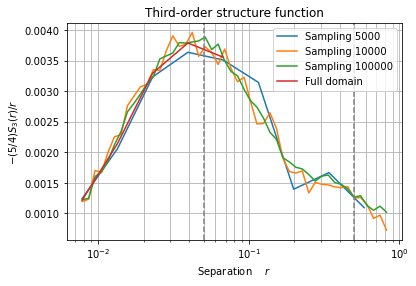

In [75]:
plt.plot(sampling_5000[0],-(5/4)*sampling_5000[1]/sampling_5000[0],label='Sampling 5000')
plt.plot(sampling_10000[0],-(5/4)*sampling_10000[1]/sampling_10000[0],label='Sampling 10000')
plt.plot(sampling_100000[0],-(5/4)*sampling_100000[1]/sampling_100000[0],label='Sampling 100000')
plt.plot(no_sampling[0],-(5/4)*no_sampling[1]/no_sampling[0],label='Full domain')
plt.axvline(0.5,color='grey',ls='--')
plt.axvline(0.05,color='grey',ls='--')
plt.legend()
plt.grid(which='major')
plt.grid(which='minor')
plt.xscale('log')
#plt.yscale('log')
#plt.xlim(0.5e-1,1)
#plt.ylim(1e-4,1e-3)
plt.title('Third-order structure function')
plt.xlabel(r'Separation $\quadr$')
plt.ylabel(r'$-(5/4)S_3(r)/r$')

Text(0, 0.5, '$-(5/4)S_3(r)/r$')

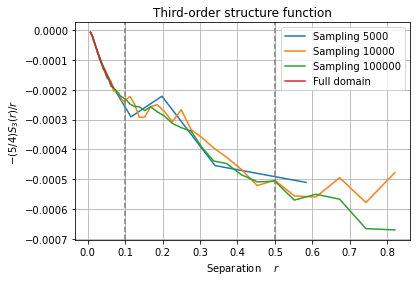

In [73]:
plt.plot(sampling_5000[0],sampling_5000[1],label='Sampling 5000')
plt.plot(sampling_10000[0],sampling_10000[1],label='Sampling 10000')
plt.plot(sampling_100000[0],sampling_100000[1],label='Sampling 100000')
plt.plot(no_sampling[0],no_sampling[1],label='Full domain')
plt.axvline(0.5,color='grey',ls='--')
plt.axvline(0.1,color='grey',ls='--')
plt.legend()
plt.grid(which='major')
plt.grid(which='minor')
#plt.xscale('log')
#plt.yscale('log')
#plt.xlim(0.5e-1,1)
#plt.ylim(1e-4,1e-3)
plt.title('Third-order structure function')
plt.xlabel(r'Separation $\quadr$')
plt.ylabel(r'$-(5/4)S_3(r)/r$')

## Multiprocessing sampling

In [4]:
# Parallel code for computing the S3 longitudinal structure
# Adapted from Natascha's code

import multiprocessing as multip
import numpy as np
from scipy import stats

def distance(x,y,boxl):
    #calculate the distance form point x=(x1,x2,x3) to point y=(y1,y2,y3)
    #boxl = 1.0
    sep = np.abs(x - y)
    dist = np.sqrt(np.sum((np.where(sep>boxl/2.,np.abs(sep-boxl),sep))**2,axis=-1))
    return dist

def S3longitudinal_Sampling_ByCoord(agrs):
    data, r, sample_coords = agrs['data'], agrs['r'], agrs['sample_coords']
    z,y,x=np.meshgrid(data['x3v'],data['x2v'],data['x1v'],indexing='ij')
    pos3D=np.stack((x,y,z),axis=-1)
    dx=data['x3f'][1]-data['x3f'][0]
    
    #build initial distance mask
    xc = pos3D[0,0,0]
    dist = distance(pos3D,xc,1.0)
    cond = ((dist>r-dx*0.6) & (dist<r+dx*0.6))
    where = np.where(cond)
    
    #print(pos3D.shape)
    
    s3sum = 0.0
    nitems = 0
    n3,n2,n1=data["RootGridSize"]
    
    assert all([coord < n1*n2*n3 for coord in sample_coords]), "The sampling coordinates should not exceed the number of grids!"
    
    for sample_coord in sample_coords:
        k,j,i = sample_coord % n3, (sample_coord//n3)%n2, ((sample_coord//n3)//n2)%n1
        
        xc = pos3D[k,j,i]
        vc=np.array([data['vel1'][k,j,i],data['vel2'][k,j,i],data['vel3'][k,j,i]])

        #roll mask to new position
        mask = ((where[0]+k)%n3,(where[1]+j)%n2 ,(where[2]+i)%n1)

        vcond = np.stack((data['vel1'][mask],data['vel2'][mask],data['vel3'][mask]),axis=-1)
        poscond = pos3D[mask]


        rel = poscond - xc
        lens = np.sqrt(np.sum(rel**2,axis=-1))
        erel = rel/lens[:,None]

        s3sum += np.sum(np.power(np.sum((vcond-vc)*erel,axis=-1),3.0))
        nitems +=poscond.shape[0]
        #print(nitems,"\n")
    
    return s3sum/float(nitems)

def make_chunks(arr, nchunks):
    assert nchunks <= len(arr), "The number of chunks cannot exceed the size of array"
    
    # Calculate the chunk size to split
    res = len(arr) % nchunks
    chunk_size = len(arr)//nchunks
    
    chunks = []
    start, end = 0,0
    for i in range(nchunks):
        window_size = chunk_size+1 if i < res else chunk_size
        
        end = start + window_size
        
        if i == nchunks -1:
            end = len(arr)
            
        chunks.append(arr[start:end])
        
        start += window_size
            
    return chunks


def S3longitudinal_Sampling_Multiproc(data,r,nsamples,nproc):
    n3,n2,n1=data["RootGridSize"]
    
    nchunks = nsamples//nproc
    sample_coords = np.random.choice(n1*n2*n3,nsamples)
    sample_chunks = make_chunks(sample_coords,nproc) # Break the coordinates into chunks 
    chunks_size = [len(chunk) for chunk in sample_chunks]

    map_agrs = [{'r':r,'data':data,'sample_coords':sample_chunk} for sample_chunk in sample_chunks]
    
    #print([len(map_agr['sample_coords']) for map_agr in map_agrs])
    #print(sum([len(map_agr['sample_coords']) for map_agr in map_agrs]))

    with multip.Pool(nproc) as pool:
        s3_stats = pool.map(S3longitudinal_Sampling_ByCoord,map_agrs)

    del map_agrs # Clean things up

    return sum([s3_stat*csize for s3_stat,csize in zip(s3_stats,chunks_size)])/nsamples



In [16]:
#import timeit
import time
cpu_count = 7
runtimes = []
for nproc in range(1,6):
    print('Number of processors: ',nproc)
    st = time.time()
    s3_val = S3longitudinal_Sampling_Multiproc(data=normal[0],r=0.09287,nsamples=100000,nproc=nproc)
    print('s3 estimate: ',s3_val)
    et = time.time()
    print(f'Processing time: {et-st} sec')
    runtimes.append(et-st)

Number of processors:  1
s3 estimate:  -0.00022736682774030314
Processing time: 159.91130995750427 sec
Number of processors:  2
s3 estimate:  -0.00022493974824357673
Processing time: 87.728844165802 sec
Number of processors:  3
s3 estimate:  -0.0002290043928537006
Processing time: 61.37628889083862 sec
Number of processors:  4
s3 estimate:  -0.0002227053471717344
Processing time: 50.493820905685425 sec
Number of processors:  5
s3 estimate:  -0.00023109493132173007
Processing time: 44.00821304321289 sec


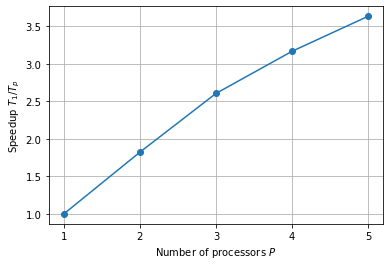

In [30]:
runtimes
speedups = [runtimes[0]/runtime for runtime in runtimes]
processors = np.arange(5) + 1
plt.plot(processors,speedups,marker='o')
plt.ylabel(r'Speedup $T_1/T_p$')
plt.xlabel(r'Number of processors $P$')
plt.xticks(processors)
plt.grid()

In [ ]:
"""
0.08411876203952225,-0.00021238156133953322
0.09287464307105925,-0.0002398889771557637
0.10254191950095472,-0.0002325353336290004
"""

In [76]:
(100000/256**3)*100

0.5960464477539062

In [35]:
rs = np.geomspace(1/128,1,50)
nproc=5
for i,r in enumerate(rs):
    s3_val = S3longitudinal_Sampling_Multiproc(data=normal[0],r=r,nsamples=100000,nproc=nproc) # 100,000 samples run
    write_line('./s3-normal-sampling-100000-50-pts.txt',f"{r},{s3_val}") 
    if i % 5 == 0:
        print('Iteration: ',i+1,'r=',r)

Iteration:  1 r= 0.0078125
Iteration:  6 r= 0.012817739937619347
Iteration:  11 r= 0.021029690509880565
Iteration:  16 r= 0.034502797302306626
Iteration:  21 r= 0.05660772901649417
Iteration:  26 r= 0.09287464307105925
Iteration:  31 r= 0.15237670677555942
Iteration:  36 r= 0.24999999999999994
Iteration:  41 r= 0.410167678003819
Iteration:  46 r= 0.6729500963161779


/tmp/ipykernel_339/1737926930.py:56: RuntimeWarning: invalid value encountered in double_scalars
  return s3sum/float(nitems)
/tmp/ipykernel_339/1737926930.py:56: RuntimeWarning: invalid value encountered in double_scalars
  return s3sum/float(nitems)
/tmp/ipykernel_339/1737926930.py:56: RuntimeWarning: invalid value encountered in double_scalars
  return s3sum/float(nitems)
/tmp/ipykernel_339/1737926930.py:56: RuntimeWarning: invalid value encountered in double_scalars
  return s3sum/float(nitems)
/tmp/ipykernel_339/1737926930.py:56: RuntimeWarning: invalid value encountered in double_scalars
  return s3sum/float(nitems)
/tmp/ipykernel_339/1737926930.py:56: RuntimeWarning: invalid value encountered in double_scalars
  return s3sum/float(nitems)
/tmp/ipykernel_339/1737926930.py:56: RuntimeWarning: invalid value encountered in double_scalars
  return s3sum/float(nitems)
/tmp/ipykernel_339/1737926930.py:56: RuntimeWarning: invalid value encountered in double_scalars
  return s3sum/float(